# BAX 452 Final Project - Group 13
## Avani Sharma, Jodie Chen, Winnie Chen

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import Lasso, LassoCV

In [15]:
df = pd.read_csv("~/Downloads/customer_shopping_data.csv")
df.head(10)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon
5,I227836,C657758,Female,28,Clothing,5,1500.40,Credit Card,24/05/2022,Forum Istanbul
6,I121056,C151197,Female,49,Cosmetics,1,40.66,Cash,13/03/2022,Istinye Park
7,I293112,C176086,Female,32,Clothing,2,600.16,Credit Card,13/01/2021,Mall of Istanbul
8,I293455,C159642,Male,69,Clothing,3,900.24,Credit Card,4/11/2021,Metrocity
9,I326945,C283361,Female,60,Clothing,2,600.16,Credit Card,22/08/2021,Kanyon


## Predict Future Sales Volume per Category

In [16]:
# Fix date parsing
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True)
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month

# Since the data in 2023 is not sufficient, filter data for 2021 and 2022 only
df_filtered = df[(df['year'] == 2021) | (df['year'] == 2022)]

# Aggregate data by category, year, and month for both sales volume and amount
monthly_sales = df_filtered.groupby(['category', 'year', 'month']).agg(quantity=('quantity', 'sum'), price=('price', 'sum')).reset_index()

# Prepare features
X = monthly_sales[['category', 'year', 'month']]
# Targets
y_sales_volume = monthly_sales['quantity']
y_sales_amount = monthly_sales['price']

# OneHotEncoder for 'category'
categorical_features = ['category']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

# Initialize two separate models for quantity and sales_amount predictions
model_sales_volume = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', RandomForestRegressor(n_estimators=100, random_state=0))])

model_sales_amount = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', RandomForestRegressor(n_estimators=100, random_state=0))])

# Split data into training and test sets for both targets
X_train, X_test, y_sales_volume_train, y_sales_volume_test = train_test_split(X, y_sales_volume, test_size=0.2, random_state=0)
X_train, X_test, y_sales_amount_train, y_sales_amount_test = train_test_split(X, y_sales_amount, test_size=0.2, random_state=0)

# Train both models
model_sales_volume.fit(X_train, y_sales_volume_train)
model_sales_amount.fit(X_train, y_sales_amount_train)

# Generate predictions for 2024 for each category in each month
categories = df['category'].unique()
predictions = []

for category in categories:
    sales_volume = 0
    sales_amount = 0
    for month in range(1, 13):
        input_data = pd.DataFrame({'category': [category], 'year': [2024], 'month': [month]})
        sales_volume += model_sales_volume.predict(input_data)[0]
        sales_amount += model_sales_amount.predict(input_data)[0]
    predictions.append({'Category': category, '2024 Predicted Sales Volume': sales_volume, '2024 Predicted Sales Amount': sales_amount})

predicted_df = pd.DataFrame(predictions)

print(predicted_df)

          Category  2024 Predicted Sales Volume  2024 Predicted Sales Amount
0         Clothing                 47478.698052                 1.424741e+07
1            Shoes                 13737.050399                 8.244566e+06
2            Books                  6821.925570                 1.033522e+05
3        Cosmetics                 20698.029442                 8.415819e+05
4  Food & Beverage                 20255.603917                 1.059368e+05
5             Toys                 13713.352211                 4.914865e+05
6       Technology                  6881.918957                 7.226015e+06
7         Souvenir                  6822.956833                 8.003328e+04


In [17]:
# Perform cross-validation
# Use negative MSE as the scoring parameter because cross_val_score aims to maximize the score
# By making MSE negative, a higher score means a lower error
scores_sales_volume = cross_val_score(model_sales_volume, X, y_sales_volume, cv=5, scoring='neg_mean_squared_error')
scores_sales_amount = cross_val_score(model_sales_amount, X, y_sales_amount, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive MSE values
mse_scores_sales_volume = -scores_sales_volume
mse_scores_sales_amount = -scores_sales_amount

print("For sales volume:")
print("Cross-validated MSE scores:", mse_scores_sales_volume)
print("Mean MSE:", mse_scores_sales_volume.mean())
print("Standard deviation of MSE:", mse_scores_sales_volume.std())
print("-----------------")
print("For sales amount:")
print("Cross-validated MSE scores:", mse_scores_sales_amount)
print("Mean MSE:", mse_scores_sales_amount.mean())
print("Standard deviation of MSE:", mse_scores_sales_amount.std())

For sales volume:
Cross-validated MSE scores: [192844.5009265  835498.58898547   9194.93443815 422113.04514667
 160741.55290619]
Mean MSE: 324078.5244805972
Standard deviation of MSE: 287824.3423061049
-----------------
For sales amount:
Cross-validated MSE scores: [1.81001967e+09 2.77859217e+09 1.60025997e+09 8.00148851e+08
 1.73912079e+09]
Mean MSE: 1745628290.3316185
Standard deviation of MSE: 630280301.498516


## Lasso and Feature Importance

In [18]:
shopping = pd.read_csv("~/Downloads/customer_shopping_data.csv")

dummy_gender = pd.get_dummies(shopping['gender'], prefix='gender')
dummy_category = pd.get_dummies(shopping['category'], prefix='category')
dummy_payment_method = pd.get_dummies(shopping['payment_method'], prefix='payment_method')
dummy_shopping_mall = pd.get_dummies(shopping['shopping_mall'], prefix='shopping_mall')

shopping = pd.concat([shopping, dummy_gender, dummy_category, dummy_payment_method, dummy_shopping_mall], axis=1)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

y = shopping['price']
x = shopping.drop(['price', 'invoice_no', 'customer_id','gender', 'category', 'payment_method', 'invoice_date', 'shopping_mall'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

lasso_cv = LassoCV(alphas=None, cv=5, random_state=1)

# Fit the model
lasso_cv.fit(x_train_scaled, y_train)

# Best alpha
print(f"Best alpha: {lasso_cv.alpha_}")

#fit lasso regression to the training data 

lasso_train = Lasso(alpha=lasso_cv.alpha_)
lasso_train.fit(x_train_scaled, y_train)

Best alpha: 1.0662558279198608


Lasso(alpha=1.0662558279198608)

In [19]:
y_pred_lasso_train = lasso_train.predict(x_test_scaled)

print("Lasso coefficients:", lasso_train.coef_)
print("Intercept:", lasso_train.intercept_)

Lasso coefficients: [ 1.29382907e+00  3.21930674e+02 -0.00000000e+00  0.00000000e+00
 -1.59895322e+01  3.70503791e+02  0.00000000e+00 -3.58272606e+01
  5.07668312e+02 -1.60532559e+01  6.62979827e+02 -3.02403037e+00
  5.88999453e-01 -0.00000000e+00 -6.54049511e-01  0.00000000e+00
 -0.00000000e+00  1.37907976e+00 -0.00000000e+00  1.68592412e-01
  0.00000000e+00 -2.41958752e-01 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00]
Intercept: 690.3771427135047


In [20]:
from sklearn.metrics import r2_score

lasso_mse = mean_squared_error(y_test, y_pred_lasso_train)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso_train))
lasso_r2 = r2_score(y_test, y_pred_lasso_train)
print("Lasso MSE:", lasso_mse)
print("Lasso RMSE:", lasso_rmse)
print("Lasso R^2:", lasso_r2)

Lasso MSE: 143717.93509043154
Lasso RMSE: 379.1014838937346
Lasso R^2: 0.8365956837578162


In [21]:
# identify important features
lasso_feature_importance = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': lasso_train.coef_})
lasso_feature_importance_sorted = lasso_feature_importance.sort_values(by='Coefficient', ascending=False)
print(lasso_feature_importance_sorted)

                            Feature  Coefficient
10              category_Technology   662.979827
8                    category_Shoes   507.668312
5                 category_Clothing   370.503791
1                          quantity   321.930674
17     shopping_mall_Forum Istanbul     1.379080
0                               age     1.293829
12              payment_method_Cash     0.588999
19             shopping_mall_Kanyon     0.168592
16  shopping_mall_Emaar Square Mall    -0.000000
6                category_Cosmetics     0.000000
23     shopping_mall_Viaport Outlet    -0.000000
22       shopping_mall_Metropol AVM    -0.000000
20   shopping_mall_Mall of Istanbul     0.000000
18       shopping_mall_Istinye Park    -0.000000
2                     gender_Female    -0.000000
24       shopping_mall_Zorlu Center    -0.000000
15        shopping_mall_Cevahir AVM     0.000000
13       payment_method_Credit Card    -0.000000
3                       gender_Male     0.000000
21          shopping

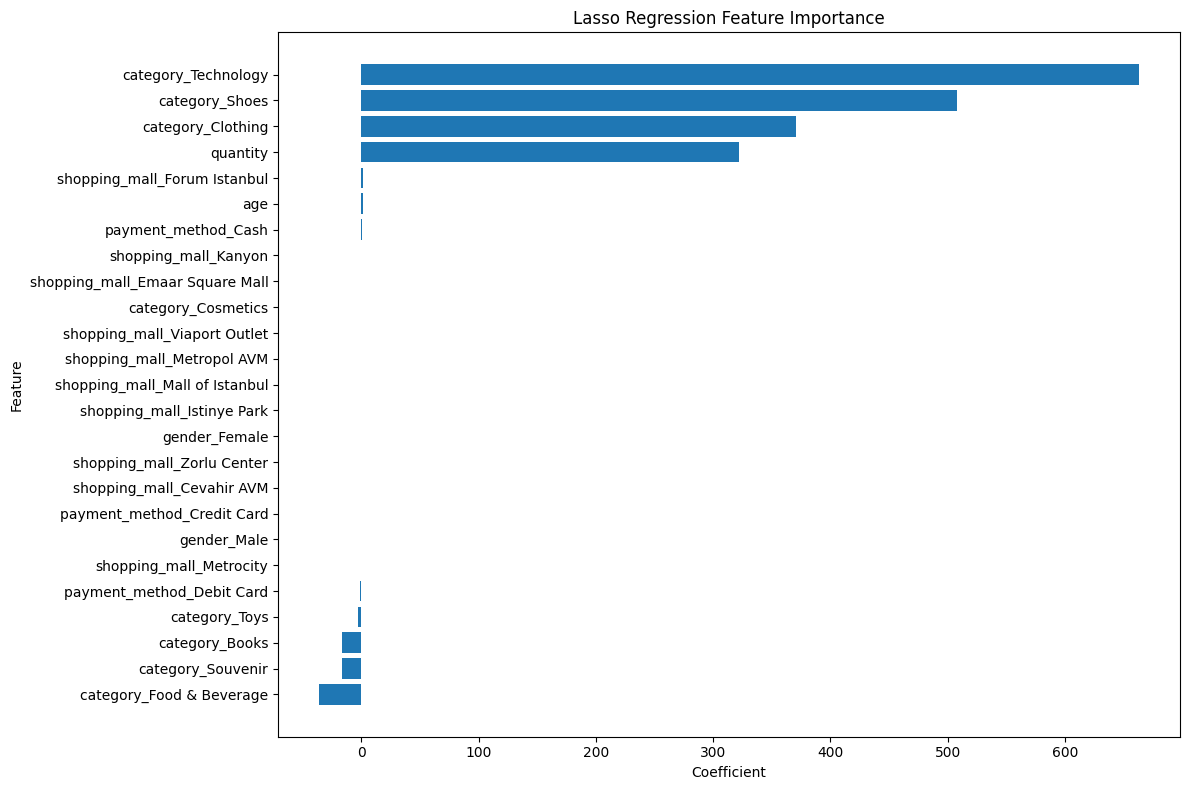

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(lasso_feature_importance_sorted['Feature'], lasso_feature_importance_sorted['Coefficient'])
plt.title('Lasso Regression Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

## Customer Segmentation

In [23]:
customer_df = pd.read_csv("~/Downloads/customer_shopping_data.csv")

# Filter out the relevant categories
relevant_categories = ['Technology', 'Shoes', 'Clothing']
filtered_df = customer_df[customer_df['category'].isin(relevant_categories)]

# Define age bins and labels for the age groups
age_bins = [18, 24, 34, 44, 54, 64, 74, 84, 94, 104]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '95-104']

# Add an age group column to the DataFrame
filtered_df = filtered_df.assign(age_group=pd.cut(filtered_df['age'], bins=age_bins, labels=age_labels, right=False))

# Create a combined segment label based on gender and age group
filtered_df = filtered_df.assign(customer_segment=filtered_df['gender'] + ' ' + filtered_df['age_group'].astype(str))

# Calculate the average spending for each segment within each category
# Since 'price' represents the total spending and not the price per item, we'll calculate the average by dividing by the number of invoices instead of quantity.
average_spending = (
    filtered_df.groupby(['category', 'customer_segment'])['price'].sum() / 
    filtered_df.groupby(['category', 'customer_segment'])['invoice_no'].nunique()
).reset_index(name='average_spending')

# Pivot the table to get the desired format for plotting
pivot_table = average_spending.pivot(index='customer_segment', columns='category', values='average_spending')

# Replace NaN with 0 for segments that might not have any spending in a particular category
pivot_table = pivot_table.fillna(0)

pivot_table.head() 

category,Clothing,Shoes,Technology
customer_segment,,,
Female 18-24,900.746678,1834.880969,3127.727273
Female 25-34,901.801368,1774.645154,3110.580205
Female 35-44,895.896441,1832.908558,3170.322581
Female 45-54,898.951452,1768.554193,3180.989583
Female 55-64,906.054911,1799.476115,3225.568182


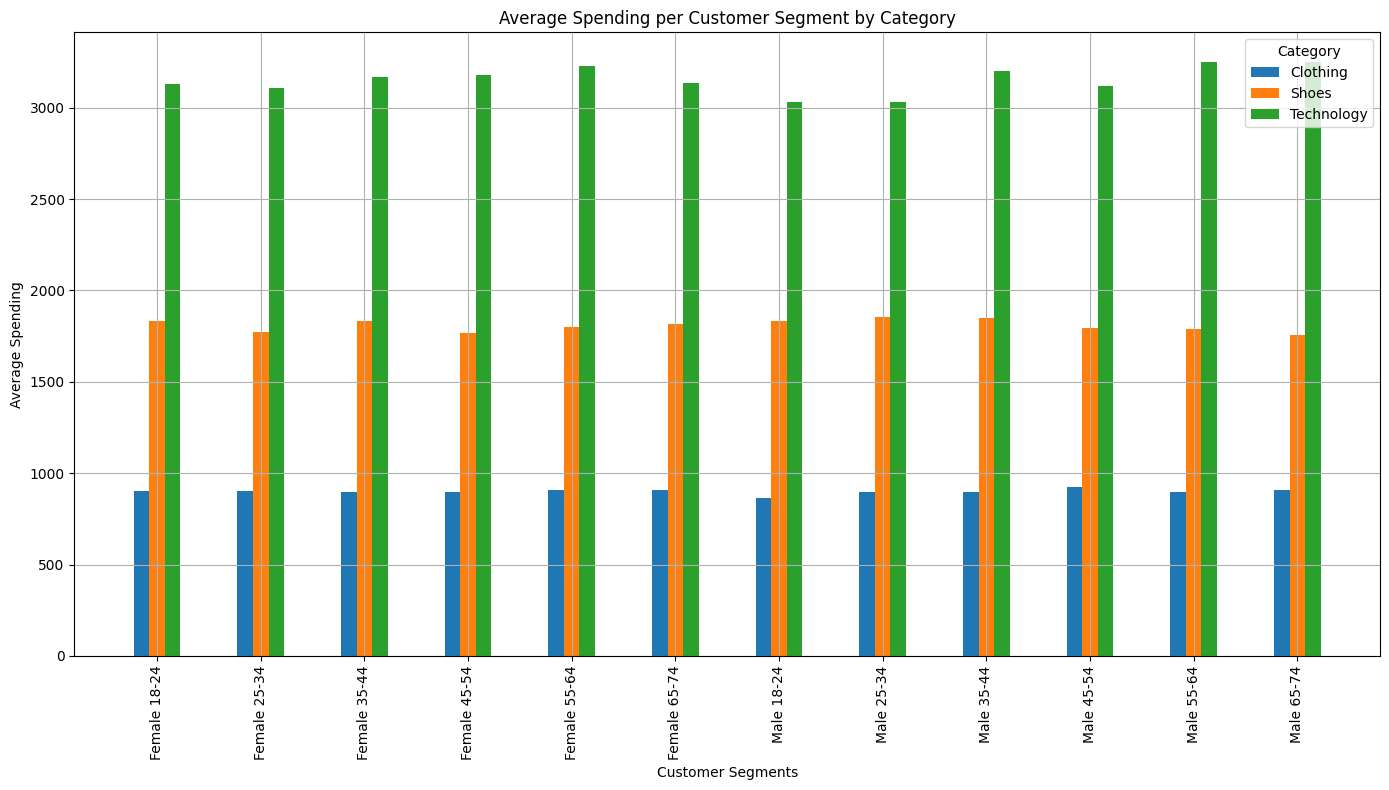

In [24]:
# Plotting the data
fig, ax = plt.subplots(figsize=(14, 8))

# We'll need to create a bar position on the x-axis for each customer segment within each category
# Calculating the bar positions
bar_width = 0.15  # the width of the bars
categories = pivot_table.columns
n_categories = len(categories)
n_segments = len(pivot_table.index)
bar_positions = dict()
for i, category in enumerate(categories):
    bar_positions[category] = [j + i*bar_width for j in range(n_segments)]

# Plotting each category
for category in categories:
    ax.bar(bar_positions[category], pivot_table[category], width=bar_width, label=category)

# Set the position and labels for X-ticks
ax.set_xticks([r + bar_width for r in range(n_segments)])
ax.set_xticklabels(pivot_table.index, rotation=90)

# Adding labels and title
plt.xlabel('Customer Segments')
plt.ylabel('Average Spending')
plt.title('Average Spending per Customer Segment by Category')

# Adding a legend and a grid
plt.legend(title='Category')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()